# Hotel Recommendation System using Keras

In [2]:
!pip install tensorflow

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow
from keras import backend as K

from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
hotel_train_data = pd.read_csv("/Users/lufthikautsar/Downloads/buat TVLK/Hotel_Recomendation_Model_Traveloka/Eksplorasi Data/Eksperimen/for_training_user.csv", sep=',')

In [10]:
hotel_train_data.head(2)

,Unnamed: 0,user_id,property_id,hotel_star_rating,site_review_rating,Bike on Rent,Cook Services,Drivers Rest Room,24 Hour Front Desk,ATM / Banking,...,Children's Park,City Shuttle Service,Clubhouse,Coffee Shop / Cafe,Computer Rental,Concierge,Conference Facility,Conference Facility,Courier Service,Courtesy Coach
0,0,U000001,H000021,0.2,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,U000002,H001054,0.6,0.375,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Pre-processing

In [11]:
df = hotel_train_data[['user_id','property_id','hotel_star_rating']]

In [12]:
#I've renamed columns for my work
df.columns =['User_id', 'Item_id', 'Rating']
df.head()

,User_id,Item_id,Rating
0,U000001,H000021,0.2
1,U000002,H001054,0.6
2,U000003,H001054,0.6
3,U000004,H001054,0.6
4,U000005,H001054,0.6


In [13]:
df.shape

(9219, 3)

In [14]:
n_users = len(df.User_id.unique())
n_users

9219

In [16]:
n_hotels = len(df.Item_id.unique())
n_hotels

1275

Create variables with the total number of unique users and item in the data, as well as the min and max ratings present in the data

In [17]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['User_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['item'] = item_enc.fit_transform(df['Item_id'].values)
n_items = df['item'].nunique()

df['rating'] = df['Rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])
n_users, n_items
print(min_rating, max_rating)

0.0 1.0


# Split the data into training and test data sets

In [47]:
X = df[['user', 'item']].values
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7375, 2), (1844, 2), (7375,), (1844,))

In [152]:
print(X_train)

[[6659  903]
 [1491  830]
 [6453   23]
 ...
 [5390  806]
 [ 860   37]
 [7270  815]]


In [153]:
print(y_train)

[0.7 1.  0.  ... 0.4 0.  0. ]


In [55]:
n_factors = 240
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [143]:
print(X_train_array)

[array([6659, 1491, 6453, ..., 5390,  860, 7270]), array([903, 830,  23, ..., 806,  37, 815])]


In [144]:
print(X_test_array)

[array([8507, 1543,  457, ..., 1323, 5558, 2191]), array([834, 917, 290, ..., 791, 724, 259])]


# Creating Neural Network

Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

Embeddings are weights that are learned to represent some specific variable like items and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [122]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
    
# add fully-connected-layers
fc1 = Dense(512, activation='relu')(x)
fc2 = tf.keras.layers.Dropout(0.2)(fc1)
out = Dense(1)(fc2)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
model.compile(optimizer = opt, loss = 'mean_absolute_error', metrics=['accuracy'])

In [123]:
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_52 (Embedding)       (None, 1, 240)       2212560     ['input_53[0][0]']               
                                                                                                  
 embedding_53 (Embedding)       (None, 1, 240)       306000      ['input_54[0][0]']               
                                                                                           

In [124]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=30,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/30
116/116 [==============================] - 11s 84ms/step - loss: 0.3441 - accuracy: 0.3511 - val_loss: 0.3436 - val_accuracy: 0.3346
Epoch 2/30
116/116 [==============================] - 9s 81ms/step - loss: 0.3285 - accuracy: 0.3511 - val_loss: 0.3292 - val_accuracy: 0.3346
Epoch 3/30
116/116 [==============================] - 9s 82ms/step - loss: 0.3138 - accuracy: 0.3511 - val_loss: 0.3145 - val_accuracy: 0.3346
Epoch 4/30
116/116 [==============================] - 9s 81ms/step - loss: 0.2991 - accuracy: 0.3511 - val_loss: 0.2995 - val_accuracy: 0.3346
Epoch 5/30
116/116 [==============================] - 10s 82ms/step - loss: 0.2833 - accuracy: 0.3511 - val_loss: 0.2841 - val_accuracy: 0.3346
Epoch 6/30
116/116 [==============================] - 10s 85ms/step - loss: 0.2682 - accuracy: 0.3511 - val_loss: 0.2688 - val_accuracy: 0.3346
Epoch 7/30
116/116 [==============================] - 9s 78ms/step - loss: 0.2530 - accuracy: 0.3511 - val_loss: 0.2540 - val_accuracy: 0.3

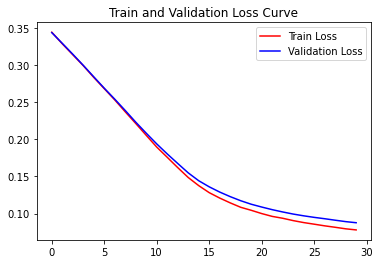

In [125]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

## Creating RMSE function for Neural Network

In [92]:
def root_mean_squared_error(y_test, y_train):
        return K.sqrt(K.mean(K.square(y_test - y_train))) 

In [118]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
     
# add fully-connected-layers
fc1 = Dense(512, activation='relu')(x)
fc2 = tf.keras.layers.Dropout(0.2)(fc1)
out = Dense(1)(fc2)

model = Model([user, item], out)
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
model.compile(optimizer = opt , loss = root_mean_squared_error, metrics=['accuracy'])

In [119]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_52 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_50 (Embedding)       (None, 1, 240)       2212560     ['input_51[0][0]']               
                                                                                                  
 embedding_51 (Embedding)       (None, 1, 240)       306000      ['input_52[0][0]']               
                                                                                           

In [120]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=30,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/30
116/116 [==============================] - 11s 85ms/step - loss: 0.4589 - accuracy: 0.3511 - val_loss: 0.4515 - val_accuracy: 0.3346
Epoch 2/30
116/116 [==============================] - 10s 84ms/step - loss: 0.4327 - accuracy: 0.3511 - val_loss: 0.4262 - val_accuracy: 0.3346
Epoch 3/30
116/116 [==============================] - 10s 85ms/step - loss: 0.4076 - accuracy: 0.3511 - val_loss: 0.4017 - val_accuracy: 0.3346
Epoch 4/30
116/116 [==============================] - 10s 83ms/step - loss: 0.3831 - accuracy: 0.3511 - val_loss: 0.3779 - val_accuracy: 0.3346
Epoch 5/30
116/116 [==============================] - 10s 84ms/step - loss: 0.3593 - accuracy: 0.3511 - val_loss: 0.3549 - val_accuracy: 0.3346
Epoch 6/30
116/116 [==============================] - 10s 84ms/step - loss: 0.3373 - accuracy: 0.3511 - val_loss: 0.3327 - val_accuracy: 0.3346
Epoch 7/30
116/116 [==============================] - 10s 84ms/step - loss: 0.3148 - accuracy: 0.3511 - val_loss: 0.3112 - val_accuracy:

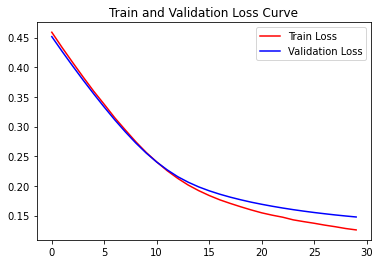

In [121]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

# Making Recommendations

In [131]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(df.Item_id)))
hotel_data[:5]

array(['H000833', 'H001003', 'H001213', 'H000216', 'H001193'], dtype='<U7')

In [137]:
user = np.array([df.User_id for i in range(len(hotel_data))])
user[:5]

array([['U000001', 'U000002', 'U000003', ..., 'U009217', 'U009218',
        'U009219'],
       ['U000001', 'U000002', 'U000003', ..., 'U009217', 'U009218',
        'U009219'],
       ['U000001', 'U000002', 'U000003', ..., 'U009217', 'U009218',
        'U009219'],
       ['U000001', 'U000002', 'U000003', ..., 'U009217', 'U009218',
        'U009219'],
       ['U000001', 'U000002', 'U000003', ..., 'U009217', 'U009218',
        'U009219']], dtype=object)

In [142]:
predictions = model.predict([X_test_array])

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()[:5]

recommended_item_ids

58/58 [==============================] - 0s 5ms/step


array([1142, 1158, 1452, 1722, 1530])

In [145]:
# print predicted scores
predictions[recommended_item_ids]

array([0.8220406, 0.8209105, 0.8208314, 0.8189192, 0.8175316],
      dtype=float32)

# Recommend Hotel Cluster for a User

In [150]:
rows = []
hotel = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)
names = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'Item_id' : hotel[i], 'User_id' : df.iloc[4,0]}))
test_data = pd.DataFrame(rows)

In [151]:
for idx, (score, name) in enumerate(sorted(zip(recommended_item_ids, names), reverse=True)):
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  1722.0  for hotel cluster:  H001074
Score:  1530.0  for hotel cluster:  H000193
Score:  1452.0  for hotel cluster:  H001100
Score:  1158.0  for hotel cluster:  H001054
Score:  1142.0  for hotel cluster:  H000021
